# Word Embedding in PyTorch

## Import the modules

In [56]:
import torch
import torch.nn as nn

from torch.optim import Adam
from torch.distributions.uniform import Uniform
from torch.utils.data import TensorDataset, DataLoader

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Create the datasets

In [57]:
inputs = torch.tensor([[1., 0., 0., 0.,], # one-hot encoding for Lewis
                       [0., 1., 0., 0.,], # ... is
                       [0., 0., 1., 0.,], # ... fast
                       [0., 0., 0., 1.,]]) # ... Lando

labels = torch.tensor([[0., 1., 0., 0.,], # "Lewis" is followed by "is"
                       [0., 0., 1., 0.,], # "is" is followed by "fast"
                       [0., 0., 0., 1.,], # "great" is not followed by anything but let's pretend that it is followed by "is"
                       [0., 1., 0., 0.,]]) # "Lando", like "Lewis", is followed by "is"


In [58]:
dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset)

## Build and train word embedding

In [68]:
seed = 45

class WordEmbedding(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(seed=seed)

        min_val = -0.5
        max_val = 0.5

        self.input1_w1 = nn.Parameter(Uniform(min_val, max_val).sample())
        self.input1_w2 = nn.Parameter(Uniform(min_val, max_val).sample())

        self.input2_w1 = nn.Parameter(Uniform(min_val, max_val).sample())
        self.input2_w2 = nn.Parameter(Uniform(min_val, max_val).sample())

        self.input3_w1 = nn.Parameter(Uniform(min_val, max_val).sample())
        self.input3_w2 = nn.Parameter(Uniform(min_val, max_val).sample())

        self.input4_w1 = nn.Parameter(Uniform(min_val, max_val).sample())
        self.input4_w2 = nn.Parameter(Uniform(min_val, max_val).sample())

        self.output1_w1 = nn.Parameter(Uniform(min_val, max_val).sample())
        self.output1_w2 = nn.Parameter(Uniform(min_val, max_val).sample())

        self.output2_w1 = nn.Parameter(Uniform(min_val, max_val).sample())
        self.output2_w2 = nn.Parameter(Uniform(min_val, max_val).sample())

        self.output3_w1 = nn.Parameter(Uniform(min_val, max_val).sample())
        self.output3_w2 = nn.Parameter(Uniform(min_val, max_val).sample())

        self.output4_w1 = nn.Parameter(Uniform(min_val, max_val).sample())
        self.output4_w2 = nn.Parameter(Uniform(min_val, max_val).sample())

        self.loss = nn.CrossEntropyLoss()
        

    def forward(self, input):
        input = input.squeeze(0)

        inputs_to_top_hidden = ((input[0] * self.input1_w1) + 
                                (input[1] * self.input2_w1) + 
                                (input[2] * self.input3_w1) + 
                                (input[3] * self.input4_w1))

        inputs_to_bottom_hidden = ((input[0] * self.input1_w2) + 
                                   (input[1] * self.input2_w2) +
                                   (input[2] * self.input3_w2) +
                                   (input[3] * self.input4_w2))


        output_1 = ((inputs_to_top_hidden * self.output1_w1) +
                    (inputs_to_bottom_hidden * self.output1_w2))
        
        output_2 = ((inputs_to_top_hidden * self.output2_w1) + 
                    (inputs_to_bottom_hidden * self.output2_w2))

        output_3 = ((inputs_to_top_hidden * self.output3_w1) + 
                    (inputs_to_bottom_hidden * self.output3_w2))

        output_4 = ((inputs_to_top_hidden * self.output4_w1) + 
                    (inputs_to_bottom_hidden * self.output4_w2))

        output_presoftmax = torch.stack([output_1, output_2, output_3, output_4])

        return output_presoftmax

    def training_step(self, batch, batch_idx, optimizer):
        input_i, label_i = batch[0], batch[1]
        output_i = self(input_i)
        loss = self.loss(output_i, label_i[0])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        return loss

In [69]:
model = WordEmbedding()
print('Before optimization, the parameters are:')
for name, param in model.named_parameters():
    print(name, torch.round(param.data, decimals=2))

Before optimization, the parameters are:
input1_w1 tensor(-0.3100)
input1_w2 tensor(0.4600)
input2_w1 tensor(0.1800)
input2_w2 tensor(0.4000)
input3_w1 tensor(-0.4500)
input3_w2 tensor(0.0600)
input4_w1 tensor(0.2900)
input4_w2 tensor(-0.4400)
output1_w1 tensor(0.2800)
output1_w2 tensor(-0.3500)
output2_w1 tensor(-0.4600)
output2_w2 tensor(-0.4000)
output3_w1 tensor(-0.0800)
output3_w2 tensor(-0.2600)
output4_w1 tensor(0.3100)
output4_w2 tensor(0.0300)


In [70]:
data = {
    'w1': [model.input1_w1.item(),
            model.input2_w1.item(),
            model.input3_w1.item(),
            model.input4_w1.item(),
           ],

    'w2': [model.input1_w2.item(),
            model.input2_w2.item(),
            model.input3_w2.item(),
            model.input4_w2.item(),
           ],
    'token': ['Lewis', 'is', 'fast', 'Lando'],
    'input': ['input1', 'input2', 'input3', 'input4']
}

df = pd.DataFrame(data)
df

,w1,w2,token,input
0,-0.313052,0.461328,Lewis,input1
1,0.183449,0.398796,is,input2
2,-0.449492,0.055456,fast,input3
3,0.286129,-0.443377,Lando,input4


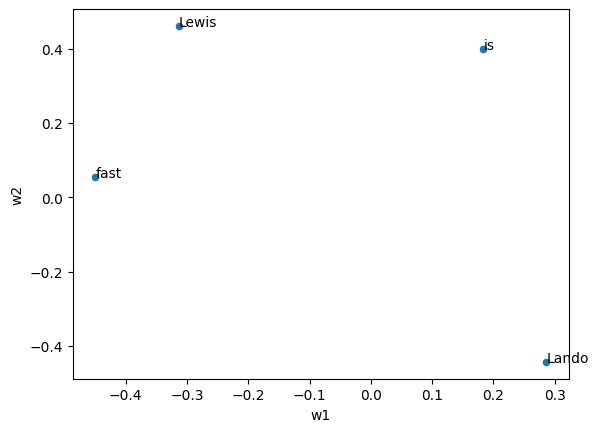

In [71]:
sns.scatterplot(data, x='w1', y='w2')

for i in range(len(df)):
    plt.text(df.w1[i], df.w2[i], df.token[i], ha='left')

plt.show()

In [72]:
epochs = 100
optimizer = Adam(model.parameters(), lr=0.1)

model.train()

for epoch in range(epochs):
    total_loss = 0
    for batch_idx, batch in enumerate(dataloader):
        loss = model.training_step(batch, batch_idx, optimizer)
        total_loss += loss

    print(f'Epoch: {epoch + 1} / {epochs} | Loss: {total_loss}')


Epoch: 1 / 100 | Loss: 5.963597297668457
Epoch: 2 / 100 | Loss: 5.257715225219727
Epoch: 3 / 100 | Loss: 4.733581066131592
Epoch: 4 / 100 | Loss: 4.040631294250488
Epoch: 5 / 100 | Loss: 3.12878155708313
Epoch: 6 / 100 | Loss: 2.1816723346710205
Epoch: 7 / 100 | Loss: 1.4227280616760254
Epoch: 8 / 100 | Loss: 0.8760302066802979
Epoch: 9 / 100 | Loss: 0.48676586151123047
Epoch: 10 / 100 | Loss: 0.24344502389431
Epoch: 11 / 100 | Loss: 0.11873573809862137
Epoch: 12 / 100 | Loss: 0.061868924647569656
Epoch: 13 / 100 | Loss: 0.03609173744916916
Epoch: 14 / 100 | Loss: 0.02368883788585663
Epoch: 15 / 100 | Loss: 0.017204949632287025
Epoch: 16 / 100 | Loss: 0.013520329259335995
Epoch: 17 / 100 | Loss: 0.011262073181569576
Epoch: 18 / 100 | Loss: 0.009784065186977386
Epoch: 19 / 100 | Loss: 0.008758747950196266
Epoch: 20 / 100 | Loss: 0.00801016017794609
Epoch: 21 / 100 | Loss: 0.007437488064169884
Epoch: 22 / 100 | Loss: 0.00698121078312397
Epoch: 23 / 100 | Loss: 0.006604247726500034
Epoch:

In [73]:
print("After optimization, the parameters are:")
for name, param in model.named_parameters():
    print(name, torch.round(param, decimals=2))

After optimization, the parameters are:
input1_w1 tensor(-2.2000, grad_fn=<RoundBackward1>)
input1_w2 tensor(-1.2600, grad_fn=<RoundBackward1>)
input2_w1 tensor(2.5000, grad_fn=<RoundBackward1>)
input2_w2 tensor(1.5600, grad_fn=<RoundBackward1>)
input3_w1 tensor(-1.1500, grad_fn=<RoundBackward1>)
input3_w2 tensor(3.1200, grad_fn=<RoundBackward1>)
input4_w1 tensor(-1.8300, grad_fn=<RoundBackward1>)
input4_w2 tensor(-1.4400, grad_fn=<RoundBackward1>)
output1_w1 tensor(1.8100, grad_fn=<RoundBackward1>)
output1_w2 tensor(-2.2000, grad_fn=<RoundBackward1>)
output2_w1 tensor(-2.6200, grad_fn=<RoundBackward1>)
output2_w2 tensor(-2.4200, grad_fn=<RoundBackward1>)
output3_w1 tensor(3.8500, grad_fn=<RoundBackward1>)
output3_w2 tensor(0.0800, grad_fn=<RoundBackward1>)
output4_w1 tensor(-0.4300, grad_fn=<RoundBackward1>)
output4_w2 tensor(1.3500, grad_fn=<RoundBackward1>)


In [74]:
data = {
    'w1': [model.input1_w1.item(),
            model.input2_w1.item(),
            model.input3_w1.item(),
            model.input4_w1.item(),
           ],

    'w2': [model.input1_w2.item(),
            model.input2_w2.item(),
            model.input3_w2.item(),
            model.input4_w2.item(),
           ],
    'token': ['Lewis', 'is', 'fast', 'Lando'],
    'input': ['input1', 'input2', 'input3', 'input4']
}

df = pd.DataFrame(data)
df

,w1,w2,token,input
0,-2.195835,-1.259021,Lewis,input1
1,2.497649,1.559809,is,input2
2,-1.145749,3.118115,fast,input3
3,-1.827839,-1.435772,Lando,input4


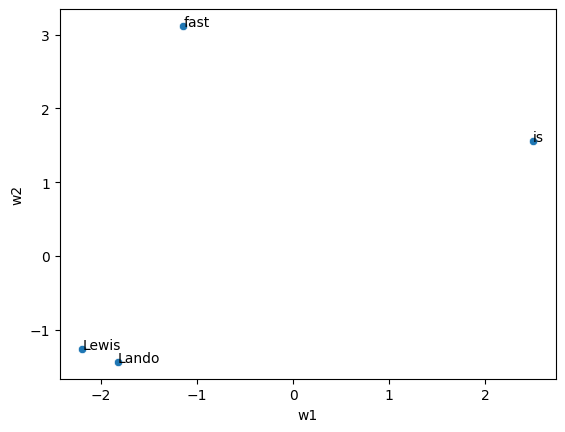

In [75]:
sns.scatterplot(df, x='w1', y='w2')

for i in range(len(data)):
    plt.text(df.w1[i], df.w2[i], df.token[i])

In [76]:
softmax = nn.Softmax(dim=0)

print(torch.round(softmax(model(torch.tensor([[1., 0., 0., 0.]]))), decimals=2))
print(torch.round(softmax(model(torch.tensor([[0., 1., 0., 0.]]))), decimals=2))
print(torch.round(softmax(model(torch.tensor([[0., 0., 1., 0.]]))), decimals=2))
print(torch.round(softmax(model(torch.tensor([[0., 0., 0., 1.]]))), decimals=2))

tensor([0., 1., 0., 0.], grad_fn=<RoundBackward1>)
tensor([0., 0., 1., 0.], grad_fn=<RoundBackward1>)
tensor([0., 0., 0., 1.], grad_fn=<RoundBackward1>)
tensor([0., 1., 0., 0.], grad_fn=<RoundBackward1>)
